<a href="https://colab.research.google.com/github/AntJuLRa/ANLP-project-/blob/dev/generation/LSTM_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text generation with LSTM**  
ANLP 2020/2021 final project  
Friederike Schreiber, Peng Chen, Anton Rabe


In [ ]:
import pickle
import dill
import numpy as np
import torch
import nltk
import random
import torch.nn as nn
import torch.nn.functional as fnc
torch.manual_seed(42)
random.seed(42)

In [ ]:
filename = 'LSTM.pkl'

In [ ]:
dill.dump_session(filename)

In [ ]:
dill.load_session(filename)

**Preparing the training data**  
Because Hip Hop lyrics contain a lot of different spellings and unique words and the data set is also quite large we filter out less frequent words and buildour training data from all 4 line phrases that contain only words from our vocabulary.  
This should help remove most unique samples and texts from languages other than english.


In [ ]:
#loading the pickled data, a list of songs
OHHLA_data = pickle.load(open( "../resources/OHHLAdata_list.p", "rb" ))

In [ ]:
flat_data = [word for song in OHHLA_data for word in song]

In [ ]:
#To reduce vocabulary size only include words that occur more than 30 times
freq_dict= nltk.FreqDist(flat_data)
valid_vocab= [word for word,freq in freq_dict.items() if freq>30]
invalid_vocab= [word for word,freq in freq_dict.items() if freq<=30]

In [ ]:
len(valid_vocab)

10844

In [ ]:
#setup an index dictonary for one hot encoding and provide a method to return adequate pytorch tensors
index_dict = dict()
for i, x in enumerate(valid_vocab):
  index_dict[x]=i+1

rev_index_dict = dict([reversed(i) for i in index_dict.items()])
rev_index_dict[0]='UNK'

def phrase_to_tensor(phrase, ind_dict):
  word_list = [word for line in phrase for word in line]
  tensor = torch.zeros(len(word_list)).long()
  for i, x in enumerate(word_list):
    try:
      tensor[i]=ind_dict[x]
    except KeyError:
      tensor[i]=0
  return tensor

In [ ]:
from itertools import groupby
#We train on sequences of four lines
verses = [list(x) for y in OHHLA_data for k, x in groupby(y, lambda x: x =='nxtvrse') if not k]

In [ ]:
def get_phrases(verse,num_lines=4,endline='endline'):
  lines = [list(x)+[endline] for k, x in groupby(verse, lambda x: x ==endline) if not k]
  res=[]
  for i,x in enumerate (lines[:len(lines)-num_lines+1]):
    res.append(lines[i:i+num_lines])
  return res

In [ ]:
#obtain a list of all possible four line phrases
list_of_phrases=[get_phrases(verse) for verse in verses]
phrases=[x for y in list_of_phrases for x in y]

In [ ]:
#obtain all indeces of phrases that only include valid vocab
invalid_phrases= []
for i,phrase in enumerate(phrases):
  for word in [word for line in phrase for word in line]:
    if freq_dict[word]<=30:
      invalid_phrases.append(i)
      break

valid_phrases = list(set(list(range(0,len(phrases)))) - set(invalid_phrases))

In [ ]:
#This leaves us with training data of ~300.000 phrases
len(valid_phrases)

297440

In [ ]:
#split phrases into random test and train set
shuffled = random.sample(valid_phrases, len(valid_phrases))
train_set= shuffled[:250000]
test_set= shuffled[250000:]

In [ ]:
#get random phrases/ random training samples for training
def random_valid_phrase(index_list):
  i= random.choice(index_list)
  return phrases[i]

In [ ]:
def random_training_tensor(index_list):    
    x=random_valid_phrase(index_list)
    phrase = phrase_to_tensor(x,index_dict)
    input = phrase[:-1]
    target = phrase[1:]
    return input, target

**LSTM for text generation**  
The basic model architecture is adopted from assignment 3.
We set the standard embedding dimension to 100.
For a large vocabulary values up to 300 are suggested.

In [ ]:
#an adapted class for an LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, embedding_dim=100):
        super(LSTM, self).__init__()
        self.i_dim= input_dim
        self.e_dim= embedding_dim
        self.h_dim= hidden_dim
        self.o_dim= output_dim
        self.n_layers= num_layers
        
        self.embedding = nn.Embedding(self.i_dim, self.e_dim)
        self.lstm = nn.LSTM(input_size=self.e_dim, hidden_size=self.h_dim, num_layers=self.n_layers)
        self.out = nn.Linear(self.h_dim,self.o_dim)
        
    
    def forward(self, inp, hidden_cell):
        embedded = self.embedding(inp)
        lstm_out, hidden = self.lstm(embedded.view(1,1,-1), hidden_cell)
        res = self.out(lstm_out.view(1, -1))
        res = fnc.log_softmax(res, dim=1)
        
        return res, hidden 
        

    def init_hidden(self):
        hidden=torch.zeros(self.n_layers,1,self.h_dim)
        cell = torch.zeros(self.n_layers,1,self.h_dim)
        return hidden, cell

In [ ]:
#a method for generating random sequences adapted from assignment 3.
#The generation will stop after either the maximum number of words (max_len) or the required number of lines (num_lines) are reached.
def generate(LSTM_model, start=['i'], max_len=150, num_lines=4, temp=0.8):
    hidden, cell = LSTM_model.init_hidden()
    prime_input = phrase_to_tensor([start], index_dict)
    predicted = start[:]

    for p in range(len(prime_input)):
        _, (hidden, cell) = LSTM_model(prime_input[p], (hidden, cell)) 
    input = prime_input[-1]
    
    line_count=0
    for p in range(max_len):
        if line_count>=num_lines:
          break

        output, (hidden, cell) = LSTM_model(input, (hidden, cell))
        
        output_dist = output.data.view(-1).div(temp).exp()
        i = int(torch.multinomial(output_dist, 1)[0]) 
        predicted_next = rev_index_dict[i]

        if predicted_next=='endline':
          line_count= line_count+1
        
        predicted.append(predicted_next)
        input = phrase_to_tensor([[predicted_next]],index_dict)

    return predicted

**Training**  
Training models with different hidden layer size and one or two hidden layers. We are using Negative Log Likelihood loss together with log softmax in the final layer.


In [ ]:
#time tracking copied from assignment 3
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
#perform one training step on a given target and input and apply the optimization
def training_step(LSTM_model, optimizer, input, target, sample_len, criterion):
    hidden, cell = LSTM_model.init_hidden()
    LSTM_model.zero_grad()
    loss = 0
    for c in range(sample_len):
        output, (hidden, cell) = LSTM_model(input[c], (hidden, cell))
        loss = loss + criterion(output, target[c].view(1))

    loss.backward()
    optimizer.step()

    return loss.item() /sample_len

In [ ]:
#train an LSTM model for n_epochs random training verses

def train(model, optimizer, criterion, n_epochs,print_every, plot_every, index_list, return_loss_array):
  loss_avg=0
  all_losses=[]
  start = time.time()
  for epoch in range(1, n_epochs+1):
    phrase = random_training_tensor(index_list)
    #on very few occasions this throws an IndexError.
    try:
      loss = training_step(model, optimizer, phrase[0], phrase[1], len(phrase[1]), criterion)
    except IndexError:
      print("Error: ",phrase)
    loss_avg += loss

    # printing and documenting the loss during training adapted from assignment 3
    if epoch % print_every == 0:
        print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(nice_format(generate(model)), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg/ plot_every)
        loss_avg = 0
    
  if return_loss_array:
    return all_losses

In [ ]:
# convert list of words output to printable format
def nice_format(output_list, meta_list=[]):
        no_meta = [x for x in output_list if x not in meta_list]
        with_linebreaks = ["\n" if x=='endline' else x for x in no_meta]
        return " ".join(with_linebreaks)

In [ ]:
#A word level network with two hidden layers
hidden_size = 128
n_layers = 2
loss_array = []
n_items= len(index_dict)

lr = 0.005
twolayer_LSTM_model = LSTM(n_items, n_items, hidden_size, n_layers, embedding_dim=100)
optimizer = torch.optim.Adam(twolayer_LSTM_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [ ]:
loss_array = loss_array +train(twolayer_LSTM_model, optimizer, criterion, 20000, 1000, 10, train_set, return_loss_array=True)

 11s (1000 5.0%) 4.5836]
i go to beg 
 catch care of wallet 
 i smoke you in my couch 
 you know i 've been ridin ' on the passin ' eyes 
 

 22s (2000 10.0%) 4.6040]
i stay away 
 you could go back 
 i would do wo n't know i am the gang 
 and you want it i'ma think there for real 
 

 32s (3000 15.0%) 4.5529]
i ca n't take a plane 
 broken i am see i 'm ridin ' 
 i cant get this game 
 no less clocks with the sun more real 
 

 40s (4000 20.0%) 5.5018]
i go to you real time to down 
 i often 
 but a beast 'fore you get like 
 i got nothing straight tryna pull up 
 

 49s (5000 25.0%) 3.4650]
i 'm like i need to do your name 
 when you with else i earn the power i 'm slapped 
 but i 'm as hell i 'm not a thug up 
 it 's like a shame make a choice 
 

 2s (6000 30.0%) 4.4782]
i made that i can give a fuck 
 you can not listen 
 hold in my chest 
 because i make a true day 
 

 11s (7000 35.0%) 4.7560]
i eat stage hard 
 we do n't care the top 
 go in the future 
 why do you stop 
 

 24

In [ ]:
#pickle the object for further training sessions
pickle.dump(twolayer_LSTM_model, open( "../resources/2lyr_word_level_LSTM.p", "wb" ))
pickle.dump(loss_array, open( "../resources/2lyr_losses.p", "wb" ))

In [ ]:
#A word level network with one larger hidden layer
hidden_size = 256
n_layers = 1
loss_array = []
n_items= len(index_dict)

lr = 0.005
biglayer_LSTM_model = LSTM(n_items, n_items, hidden_size, n_layers, embedding_dim=100)
optimizer = torch.optim.Adam(biglayer_LSTM_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [ ]:
loss_array = loss_array +train(biglayer_LSTM_model, optimizer, criterion, 20000, 1000, 10, train_set, return_loss_array=True)

 2s (1000 5.0%) 5.8368]
i 'll can get this game of your life i 'm a benz 
 they wo n't told me and playa are 
 i want a high to the game of fact 
 i 'm my past they do n't believe the shit 
 

 5s (2000 10.0%) 4.7795]
i said i 'm coming with your ass in the world 
 i do n't care about me to your dick 
 do n't know what i do you 
 just about to god 's like the ice 's in the next 
 

 11s (3000 15.0%) 4.9042]
i do n't 
 do what they say and if you kill the drippin ' 
 you wan na find we wan na like me 
 so when you like they ai n't no stack both 'll run in the top 
 

Error:  (tensor([    4,  3922,  4026,  1362,    67,  4153, 10844,   206, 10844,   206,
        10844,   206,    14,    24,   972,     8,  6139,   545,    54,   704,
        10844,   206, 10844,   206, 10844,   206,    14,    26,   277,    48,
           89,  1245,   155,  5650, 10844,   206, 10844,   206, 10844,   206,
           14,   616,  3280,  2591,    79,   998,    37,    24, 10844,   206,
        10844,   206, 10844,

In [ ]:
pickle.dump(biglayer_LSTM_model, open( "../resources/biglyr_word_level_LSTM.p", "wb" ))
pickle.dump(loss_array, open( "../resources/biglyr_losses.p", "wb" ))

In [ ]:
from matplotlib import pyplot as plt

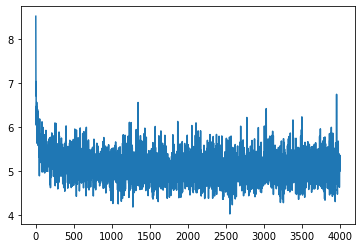

In [ ]:
#the training losses don't really go down because of the very big dataset
plt.plot(loss_array)

**Try a smaller dataset and vocabulary**  
The large dataset and large vocabulary leads to impratical training time and may contain differences that are to large for proper fitting.
We decided to chose a higher treshold for our valid vocabulary.  This should lead to a smaller output layer and more cohesive data.

In [ ]:
small_valid_vocab= [word for word,freq in freq_dict.items() if freq>150]
big_invalid_vocab= [word for word,freq in freq_dict.items() if freq<=150]

In [ ]:
len(small_valid_vocab)

3628

In [ ]:
invalid_phrases= []
for i,phrase in enumerate(phrases):
  for word in [word for line in phrase for word in line]:
    if freq_dict[word]<=150:
      invalid_phrases.append(i)
      break

valid_phrases = list(set(list(range(0,len(phrases)))) - set(invalid_phrases))

In [ ]:
index_dict = dict()
for i, x in enumerate(small_valid_vocab):
  index_dict[x]=i+1

rev_index_dict = dict([reversed(i) for i in index_dict.items()])

#split phrases into random test and train set
shuffled = random.sample(valid_phrases, len(valid_phrases))
train_set= shuffled[:50000]
test_set= shuffled[50000:]

In [ ]:
#A word level network with one big layer trained on fewer samples with smaller vocabulary.
hidden_size = 200
n_layers = 2
loss_array = []
n_items= len(index_dict)

lr = 0.005
smallvocab2_LSTM_model = LSTM(n_items, n_items, hidden_size, n_layers, embedding_dim=100)
optimizer = torch.optim.Adam(smallvocab2_LSTM_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [ ]:
loss_array = loss_array +train(smallvocab2_LSTM_model, optimizer, criterion, 50000, 1000, 10, train_set, return_loss_array=True)

 10s (1000 2.0%) 5.3480]
i want you 
 they just do is that 
 i just know i 'll wan like it 
 and you love me 
 

 19s (2000 4.0%) 5.7999]
i just feel seem 
 gave the sitting 
 talk it 
 the fo fame for nights and fuck you how he got ta dj the last 
 

 28s (3000 6.0%) 3.6872]
i do n't like you can could 
 do n't give no make trapped niggaz if a place 
 and i was off wan na take a 
 and i ai n't see you 
 

 39s (4000 8.0%) 4.2244]
i feel what i do n't 
 to the do it out 
 you hear me but you came 
 i know where the head for the morning 
 

Error:  (tensor([3628,    4,   60,  287,   15,    4,   75,   34,  443,  512,   14, 2592,
          53,  139,   14,  167,   27,   62,   14,  376,    4,   60,  138,   24,
        2448]), tensor([   4,   60,  287,   15,    4,   75,   34,  443,  512,   14, 2592,   53,
         139,   14,  167,   27,   62,   14,  376,    4,   60,  138,   24, 2448,
          14]))
Error:  (tensor([ 322,   14, 3628,   14,  209,    4,  493,  494,  202,   24, 1754,   37,
    

In [ ]:
pickle.dump(smallvocab2_LSTM_model,open("../resources/smallvocab2.p","wb"))
pickle.dump(loss_array,open("../resources/smallvocabloss2.p","wb"))
pickle.dump(shuffled,open("../resources/datasplit2.p","wb"))
pickle.dump(optimizer,open("../resources/optimizer2.p","wb"))

In [ ]:
shuffle = pickle.load(open("../resources/datasplit2.p","rb"))
smallvocab2LSTM_model = pickle.load(open("../resources/smallvocab2.p","rb"))
loss_array = pickle.load(open("../resources/smallvocabloss2.p","rb"))
optimizer = pickle.load(open("../resources/optimizer2.p","rb"))
criterion = nn.NLLLoss()

In [ ]:
train_set= shuffle[:50000]
test_set= shuffle[50000:]

In [ ]:
loss_array = loss_array +train(smallvocab2_LSTM_model, optimizer, criterion, 50000, 1000, 10, train_set, return_loss_array=True)

Error:  (tensor([1384, 1384, 1384, 1384, 1384,   14,   26,   27, 1641, 3628, 1544, 3467,
          14,  322,   14,  227,   24,  498,  202]), tensor([1384, 1384, 1384, 1384,   14,   26,   27, 1641, 3628, 1544, 3467,   14,
         322,   14,  227,   24,  498,  202,   14]))
 45s (1000 2.0%) 5.0274]
i know they lock me 
 come at in my life 
 i wan na make you 
 i know this is and to your head 
 

Error:  (tensor([  13,  105,   38,   71,   11,   14,   24, 3628,  223,  144,   14,   70,
          20,   21,   49,   14, 1411,  362, 2706]), tensor([ 105,   38,   71,   11,   14,   24, 3628,  223,  144,   14,   70,   20,
          21,   49,   14, 1411,  362, 2706,   14]))
 33s (2000 4.0%) 4.0008]
i 'm trying to go in my new homeboy that i make you 're 
 and i 'm the best and i do n't know 
 i 'm from my heart fuck me 
 just lay down 
 

 22s (3000 6.0%) 4.0668]
i 'm just the tryin ' 
 yeah i 'm not a lil ' in me 
 just as i 'm looking at this girl 
 to kick me home i want you to make it girl 
 



**Generate from different models**
Here we use different pickled models that we previously trained to generate lists of four line phrases that can be used as data for classification and evaluation.

In [ ]:
twolyr = pickle.load(open("../resources/2lyr_word_level_LSTM(2).p","rb"))

In [ ]:
onelyr = pickle.load(open("../resources/biglyr_word_level_LSTM(1).p","rb"))

In [ ]:
onlyr_list= []
for x in range(100):
  beginning= random_valid_phrase(valid_phrases)[0][0:1]
  onlyr_list.append(nice_format(generate(onelyr, beginning)))

In [ ]:
pickle.dump(onlyr_list, open("../resources/onelyr_list.p","wb"))

In [ ]:
twolyr_list= []
for x in range(100):
  beginning= random_valid_phrase(valid_phrases)[0][0:1]
  twolyr_list.append(nice_format(generate(twolyr, beginning)))

In [ ]:
pickle.dump(twolyr_list, open("../resources/twolyr_list.p","wb"))

In [ ]:
#generate a list of 100 random outputs for evaluation.
random_list= []
dist = nltk.DictionaryProbDist(freq_dict,normalize=True)
for x in range(100):
  length= random.choice(range(40,100))
  output= []
  for y in range(length):
    output.append(dist.generate())
  random_list.append(nice_format(output, ['nxstsng','nxtvrse']))

In [ ]:
pickle.dump(random_list, open("../resources/random_list.p","wb"))